# Анализ данных и первичная модель

In [44]:
import os
import requests as r
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sklearn
import sklearn.metrics
import sklearn.model_selection
from catboost import Pool
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

%matplotlib inline
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

In [18]:
dirs = {
    'raw_data':Path('raw_data'),
    'data_zip':Path('raw_data')/Path('data.zip'),
    'csv':Path('raw_data')/Path('heart_cleveland_upload.csv')
}
TEST_SIZE = 0.1# размер тестовой выборки

# 1. Get Data

In [19]:
#https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
def download_file_from_google_drive(file_id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = r.Session()

    response = session.get(URL, params = { 'id' : file_id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [20]:
if  not dirs['raw_data'].exists(): # создаем папку, где будем хранить данные
    dirs['raw_data'].mkdir()

#данные лежат на гугл диске. Или брать тут kaggle datasets download -d cherngs/heart-disease-cleveland-uci
if not dirs['csv'].exists(): # если нет данных
    download_file_from_google_drive('1q2ehxJdWkP-ak84wIc6GWRhCC3bgSTC4',dirs['data_zip'])#качаем
    with zipfile.ZipFile(dirs['data_zip'], 'r') as zip_ref:
        zip_ref.extractall(str(dirs['raw_data']))

# 2. Analyse data

age: age in years

sex: sex (1 = male; 0 = female)

cp: chest pain type
-- Value 0: typical angina
-- Value 1: atypical angina
-- Value 2: non-anginal pain
-- Value 3: asymptomatic

trestbps: resting blood pressure (in mm Hg on admission to the hospital)

chol: serum cholestoral in mg/dl

fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

restecg: resting electrocardiographic results
-- Value 0: normal

-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

thalach: maximum heart rate achieved

exang: exercise induced angina (1 = yes; 0 = no)

oldpeak = ST depression induced by exercise relative to rest

slope: the slope of the peak exercise ST segment

-- Value 0: upsloping

-- Value 1: flat

-- Value 2: downsloping

ca: number of major vessels (0-3) colored by flourosopy

thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

and the label

condition: 0 = no disease, 1 = disease

In [21]:
data_table = pd.read_csv(dirs['csv'])
print(data_table.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  


In [22]:
print(data_table.shape)


(297, 14)


In [23]:
print(data_table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB
None


In [24]:
data_table.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


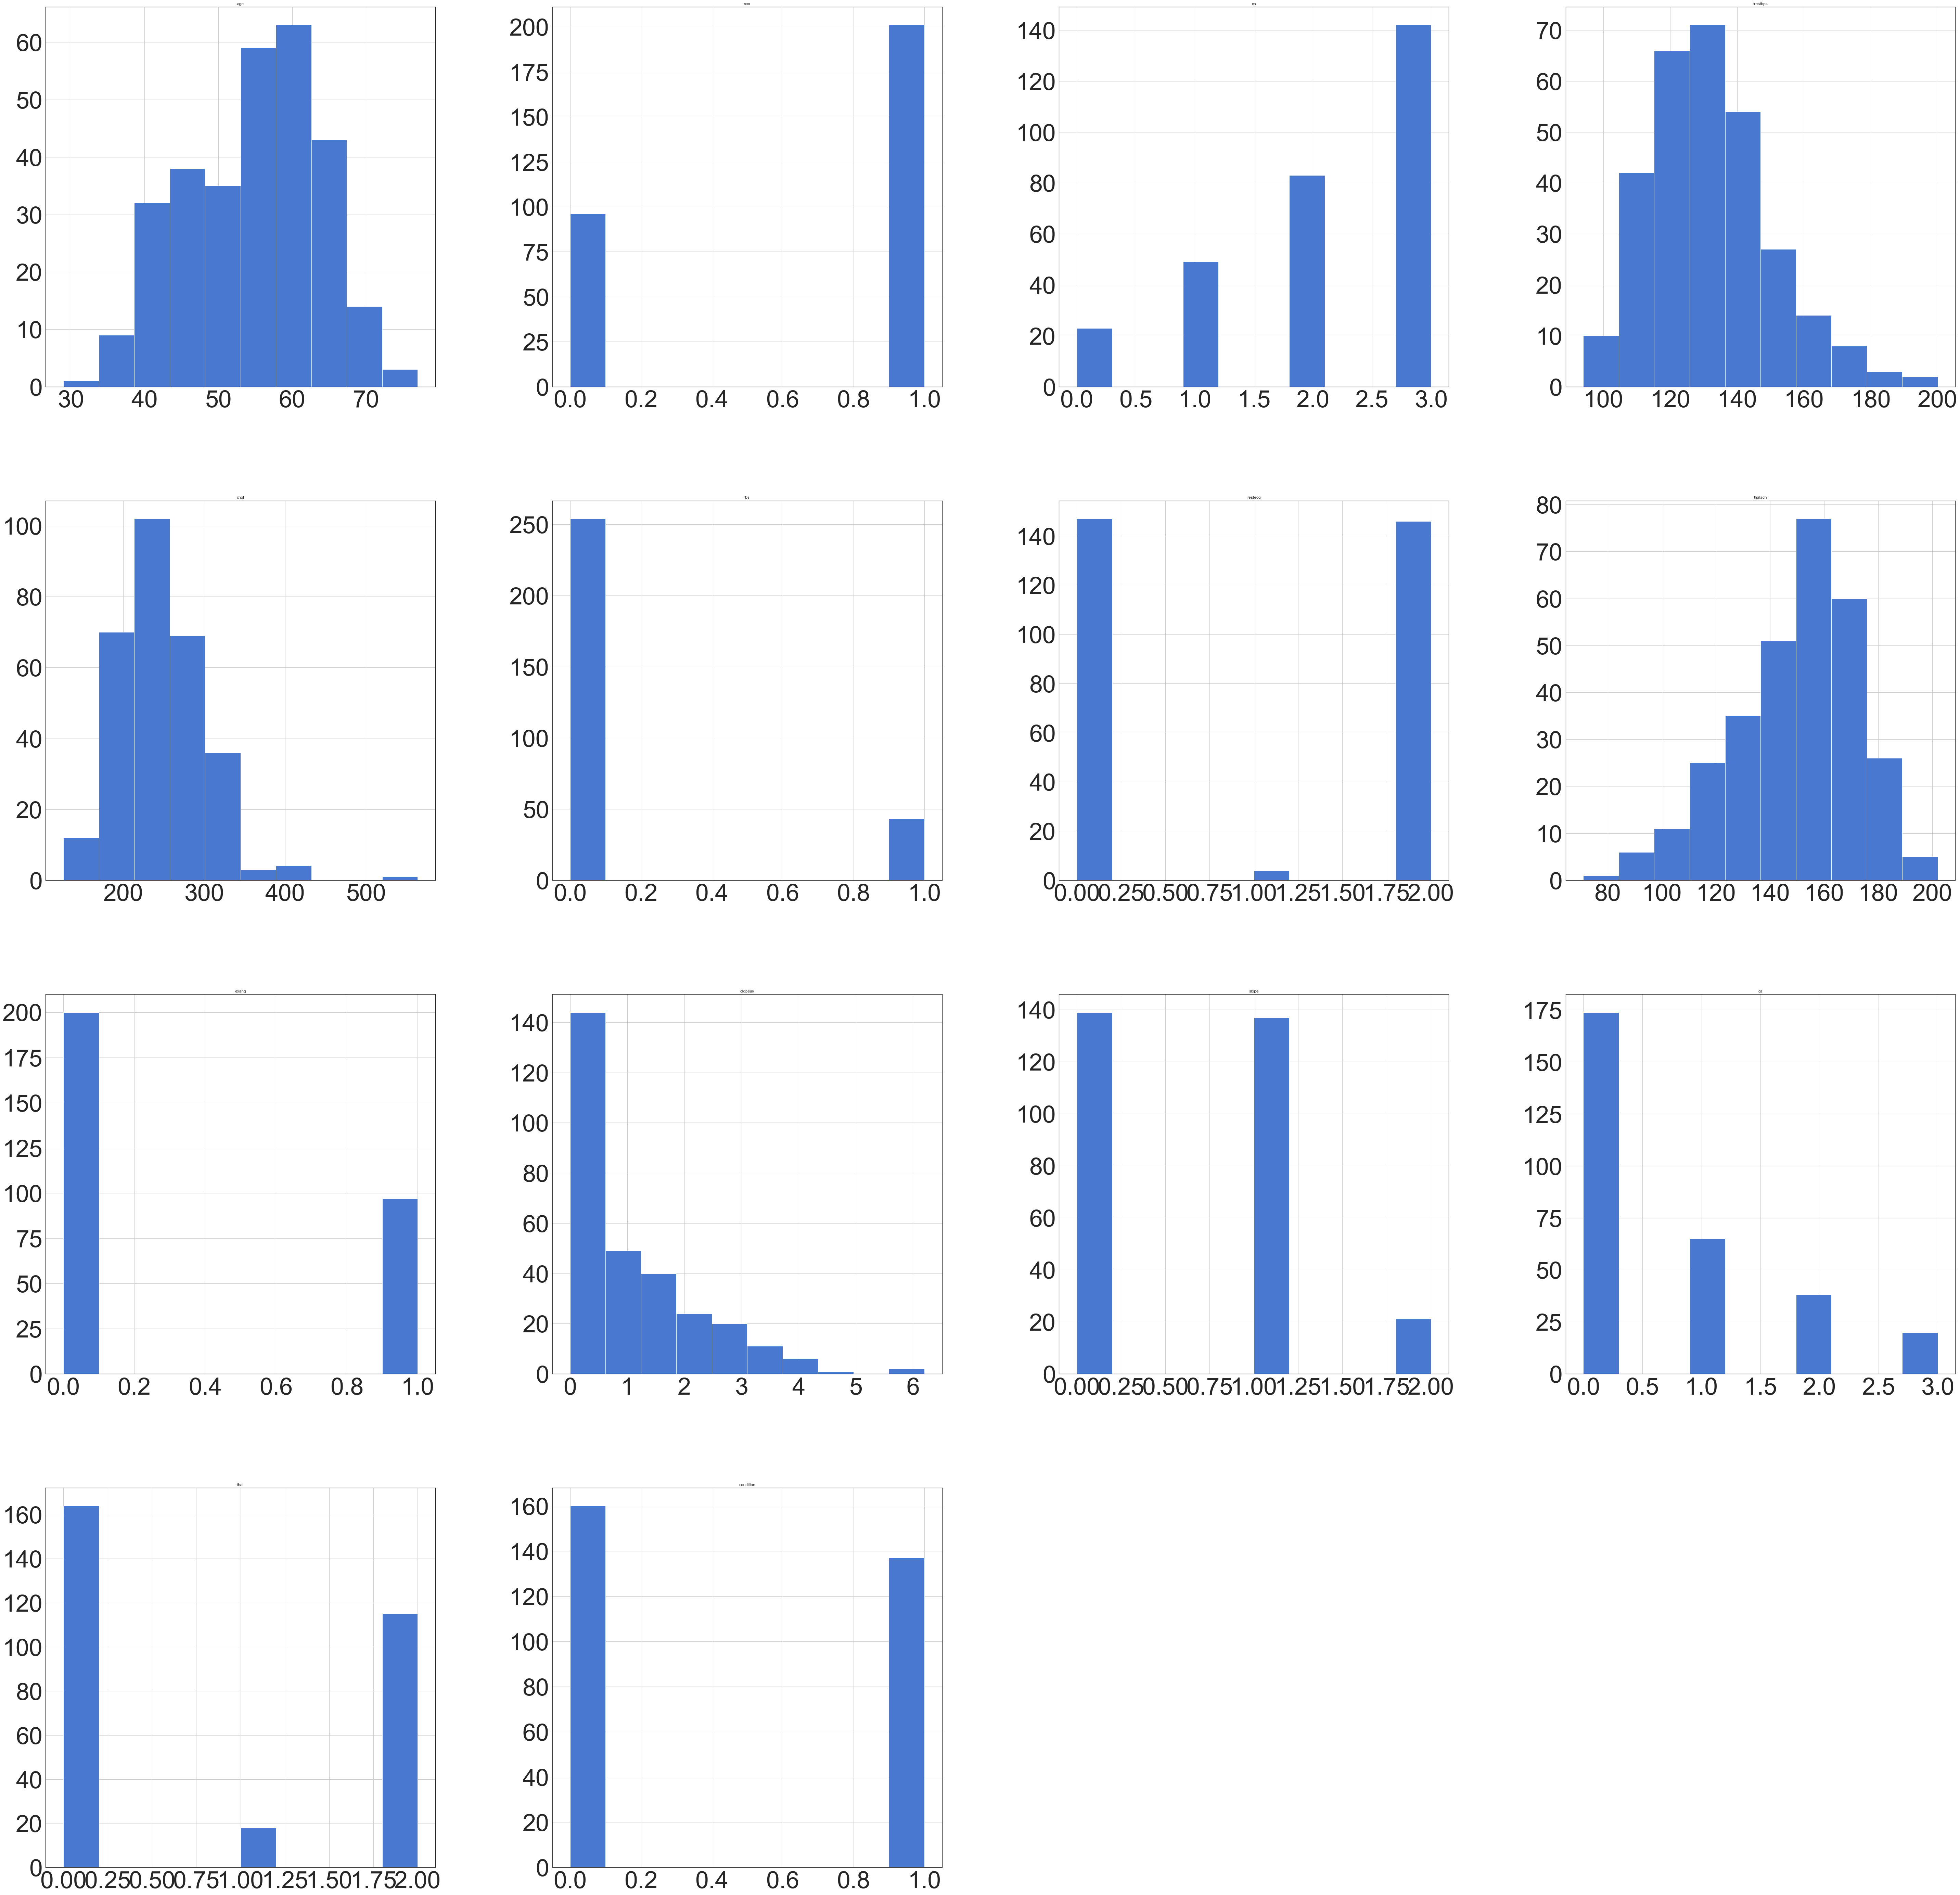

In [25]:
data_hist = data_table.hist(figsize = [100,100],xlabelsize = 70,ylabelsize = 70)

<AxesSubplot:>

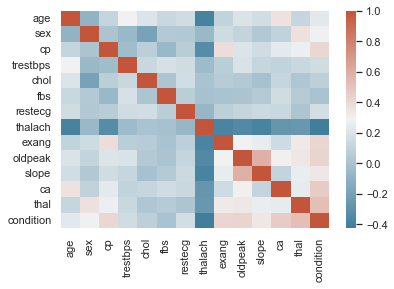

In [26]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(data_table.corr(),cmap = cmap)

как видно, с целевым значением condition много что коррелирует



thalach: maximum heart rate achieved
как видно, этот признак коррелирует с другими, что может быть плохо

Данные хорошие, но средний возраст 54 года, хотя средний возраст людей 32.5 ( средняя продолжительность жизни 75), но в возрасте чаще происходят заболевания сердца

In [28]:
print(data_table.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  


# 3. test/train split

In [33]:
cat_features = [1,2,5,6,8,10,12]#sex cp fbs restecg exang slope thal
data_pool = Pool(data=data_table.drop(columns=['condition']), label=data_table['condition'], cat_features=cat_features)
X_train, X_validation, y_train, y_validation = train_test_split(data_table.drop(columns=['condition']), data_table['condition'], train_size=0.8, random_state=42)


# 4. Первичная модель

Попробуем catboost, потому что он крутой

recall для нас самая важная метрика

In [36]:
model = CatBoostClassifier(
    #iterations=50,
    random_seed=42,
    learning_rate=0.005,
    custom_loss=['AUC', 'Accuracy','Recall'],
    use_best_model=True
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Валидация

In [40]:
eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

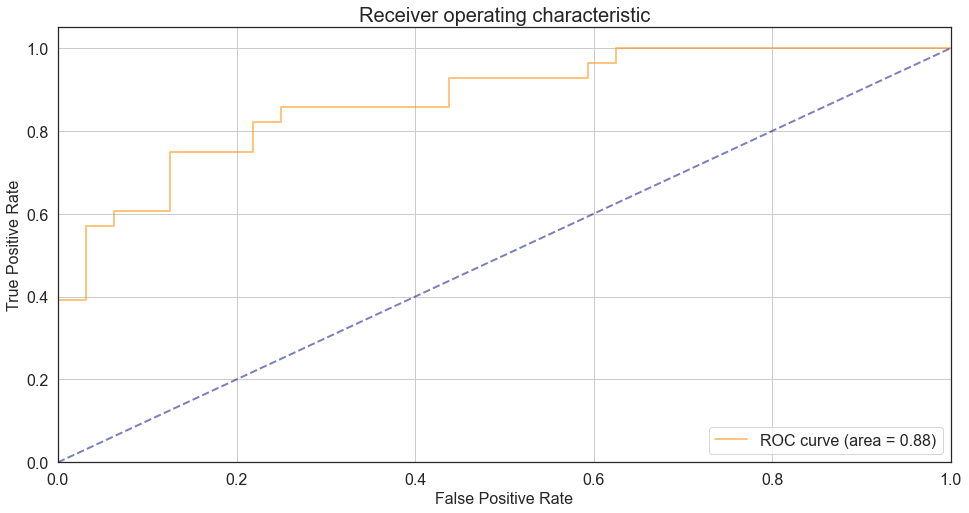

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [45]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

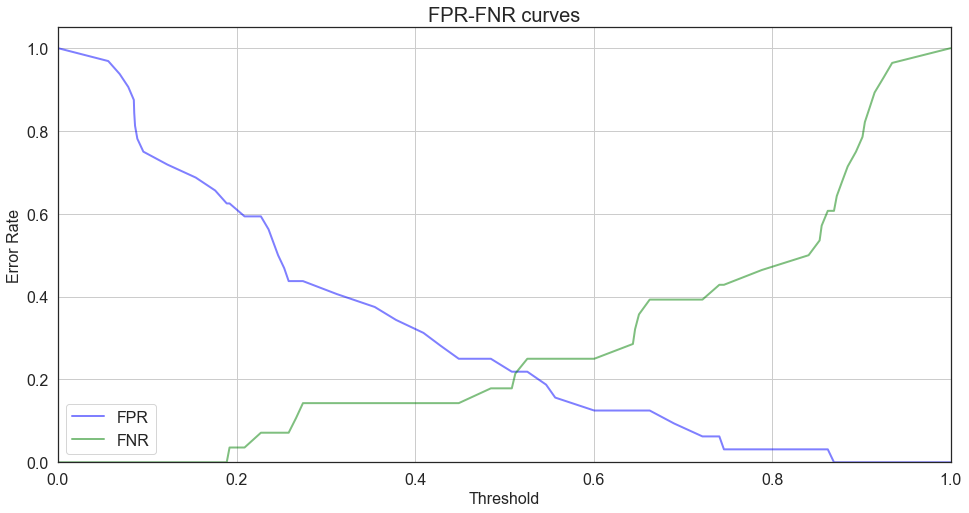

In [46]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()